In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from pathlib import Path

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm

import iridia_af.hyperparameters as hp
import config as cfg
from model import CNNModel, CNNModelConfig
from iridia_af.record import create_record

In [6]:
# folder_name = "20230701-161104"
folder_name = "20230720-164047"
folder_path = Path(hp.LOG_DL_PATH, folder_name)
assert folder_path.exists()

model_path = Path(folder_path, "model.pt")
assert model_path.exists()
#
config = CNNModelConfig(cfg.WINDOW_SIZE)
model = CNNModel(config)
model.load_state_dict(torch.load(model_path))
model.float()
model.eval()

# folder path
folder_path.absolute()

/Users/cedriculb/Documents/dev/iridia-af/examples/dl/log/20230720-164047


CNNModel(
  (block1): ResidualBlock(
    (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_shortcut): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_shortcut): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padd

In [7]:
metadata_df = pd.read_csv(hp.METADATA_PATH)
record = create_record("record_104", metadata_df, hp.RECORDS_PATH)
record.load_ecg(clean_front=True)

In [8]:
all_y_pred = [[] for _ in range(len(record.ecg[0]))]
for i in tqdm(range(0, len(record.ecg[0]) - cfg.WINDOW_SIZE, cfg.TESTING_STEP)):
    x = torch.tensor(record.ecg[0][i:i + cfg.WINDOW_SIZE, 0].copy()).float()
    x = x.unsqueeze(0).unsqueeze(0)
    y_pred = model(x)
    for j in range(i, i + cfg.WINDOW_SIZE):
        all_y_pred[j].append(y_pred.detach().numpy()[0][0])

  0%|          | 0/2108 [00:00<?, ?it/s]

In [9]:
y_pred = []
for i in tqdm(all_y_pred):
    if len(i) == 0:
        y_pred.append(0)
    else:
        y_pred.append(np.mean(i))

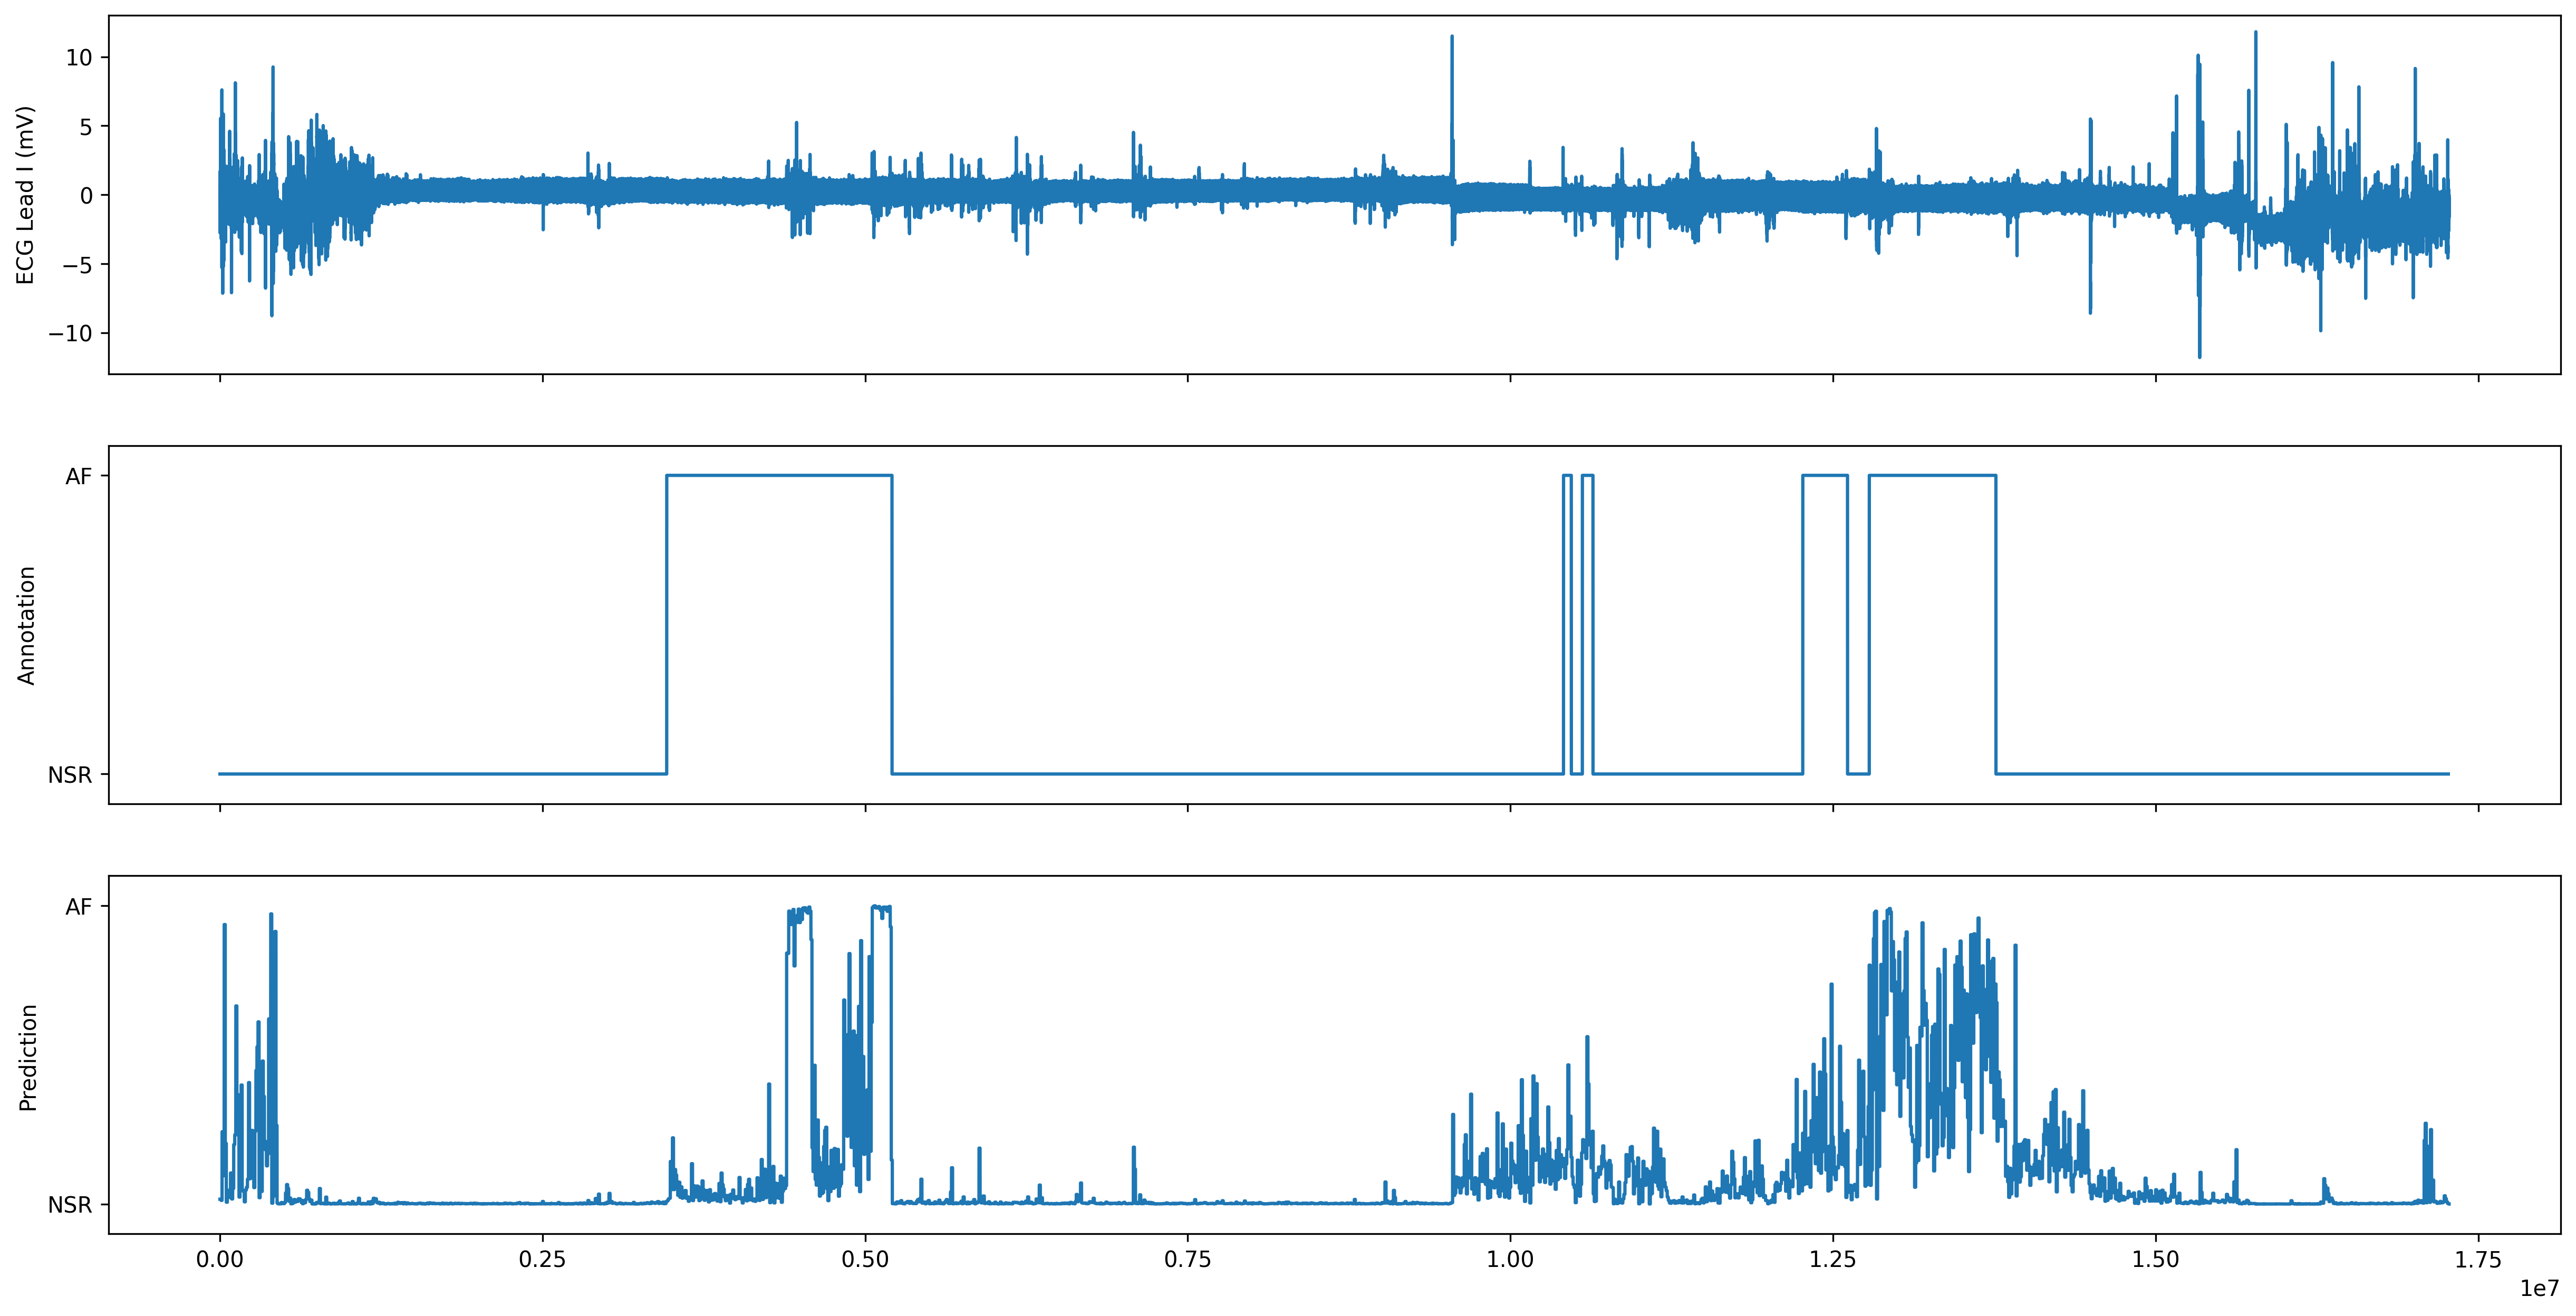

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

ax_index = 0
ax[ax_index].plot(record.ecg[0][:, 0])
ax[ax_index].set_ylabel("ECG Lead I (mV)")
ax_index += 1

ax[ax_index].plot(record.ecg_labels[0])
ax[ax_index].set_ylim(-0.1, 1.1)
ax[ax_index].set_yticks([0, 1])
ax[ax_index].set_yticklabels(["NSR", "AF"])
ax[ax_index].set_ylabel("Annotation")
ax_index += 1

ax[ax_index].plot(y_pred)
ax[ax_index].set_ylim(-0.1, 1.1)
ax[ax_index].set_yticks([0, 1])
ax[ax_index].set_yticklabels(["NSR", "AF"])
ax[ax_index].set_ylabel("Prediction")
ax_index += 1